Source: https://www.kaggle.com/yihdarshieh/my-training

This is the kernel that I will try to replicate in this notebook

In [1]:
import os
import sys
import json
import tensorflow as tf # Yes, we are going to play with Tensorflow 2!
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import absl # For using flags without tf.compat.v1.flags.Flag
import datetime

In [2]:
# Input data files are available in the "../input/" directory.
IS_KAGGLE = True
INPUT_DIR = "/home/jupyter/"

In [3]:
# The original Bert Joint Baseline data.
BERT_JOINT_BASE_DIR = os.path.join("bert-joint-baseline")

# This nq dir contains all files for publicly use.
NQ_DIR = os.path.join("nq-competition")

In [4]:
# If you want to use your own .tfrecord or new trained checkpoints, you can put them under you own nq dir (`MY_OWN_NQ_DIR`)
# Default to NQ_DIR. You have to change it to the dir containing your own working files.
MY_OWN_NQ_DIR = NQ_DIR

In [5]:
# For local usage.
if not os.path.isdir(INPUT_DIR):
    IS_KAGGLE = False
    INPUT_DIR = "./"
    NQ_DIR = "./"
    MY_OWN_NQ_DIR = "./"

In [6]:
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/jupyter/results.txt
/home/jupyter/EDA of train_Data.ipynb
/home/jupyter/.bash_logout
/home/jupyter/.profile
/home/jupyter/tf2_0_baseline_w_bert.py
/home/jupyter/Sequence Classification.ipynb
/home/jupyter/TF_Datasets.ipynb
/home/jupyter/Hugging Face.ipynb
/home/jupyter/.bashrc
/home/jupyter/bert-joint-baseline/vocab-nq.txt
/home/jupyter/bert-joint-baseline/bert_config.json
/home/jupyter/bert-joint-baseline/bert_joint.ckpt.data-00000-of-00001
/home/jupyter/bert-joint-baseline/bert_joint.ckpt.index
/home/jupyter/bert-joint-baseline/nq-train.tfrecords-00000-of-00001
/home/jupyter/.cache/jedi/CPython-35-32/36715319fe4a3b1b3277ff703c26d34fe62107ced96fbf165adfeb9ce38faff2-5d1a627312e359c1b23d70912865c24aa35ed4b320643bc54774ad039e861fee.pkl
/home/jupyter/.cache/jedi/CPython-35-32/36715319fe4a3b1b3277ff703c26d34fe62107ced96fbf165adfeb9ce38faff2-39868fd7b0a5bb75fd2b8a95d723ecb4082936cd933a87321342309337077a85.pkl
/home/jupyter/.cache/jedi/CPython-35-32/36715319fe4a3b1b3277ff703c26d34fe621

In [7]:
# NQ_DIR contains some packages / modules
sys.path.append(NQ_DIR)
sys.path.append(os.path.join(NQ_DIR, "transformers"))

In [8]:
from nq_flags import DEFAULT_FLAGS as FLAGS
from nq_flags import del_all_flags
from nq_dataset_utils import *

In [9]:
import sacremoses as sm
import transformers
from adamw_optimizer import AdamW

In [10]:
PRETRAINED_MODELS = {
    "BERT": [
        'bert-base-uncased',
        'bert-large-uncased',
        'bert-base-cased',
        'bert-large-cased',
        'bert-base-multilingual-uncased',
        'bert-base-multilingual-cased',
        'bert-base-chinese',
        'bert-base-german-cased',
        'bert-large-uncased-whole-word-masking',
        'bert-large-cased-whole-word-masking',
        'bert-large-uncased-whole-word-masking-finetuned-squad',
        'bert-large-cased-whole-word-masking-finetuned-squad',
        'bert-base-cased-finetuned-mrpc'
    ],
    "DISTILBERT": [
        'distilbert-base-uncased',
        'distilbert-base-uncased-distilled-squad'
    ]
}

In [11]:
flags = absl.flags
del_all_flags(flags.FLAGS)

In [12]:
flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

In [13]:
vocab_file = os.path.join(NQ_DIR, "vocab-nq.txt")

flags.DEFINE_string("vocab_file", vocab_file,
                    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_integer(
    "max_seq_length_for_training", 512,
    "The maximum total input sequence length after WordPiece tokenization for training examples. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "max_seq_length", 512,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_float(
    "include_unknowns_for_training", 0.02,
    "If positive, for converting training dataset, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_float(
    "include_unknowns", -1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

In [14]:
if os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq_train.tfrecord")
elif os.path.isfile(os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")):
    TRAIN_TF_RECORD = os.path.join(MY_OWN_NQ_DIR, "nq-train.tfrecords-00000-of-00001")
else:
    TRAIN_TF_RECORD = os.path.join(BERT_JOINT_BASE_DIR, "nq-train.tfrecords-00000-of-00001")

In [15]:
flags.DEFINE_string("train_tf_record", TRAIN_TF_RECORD,
                    "Precomputed tf records for training dataset.")

flags.DEFINE_string("valid_tf_record", os.path.join(NQ_DIR, "nq_valid.tfrecord"),
                    "Precomputed tf records for validation dataset.")

flags.DEFINE_string("valid_small_tf_record", os.path.join(NQ_DIR, "nq_valid_small.tfrecord"),
                    "Precomputed tf records for a smaller validation dataset.")

flags.DEFINE_string("valid_tf_record_with_labels", "nq_valid_with_labels.tfrecord",
                    "Precomputed tf records for validation dataset with labels.")

flags.DEFINE_string("valid_small_tf_record_with_labels", "nq_valid_small_with_labels.tfrecord",
                    "Precomputed tf records for a smaller validation dataset with labels.")


In [16]:
# This file should be generated when the kernel is running using the provided test dataset!
flags.DEFINE_string("test_tf_record", "nq_test.tfrecord",
                    "Precomputed tf records for test dataset.")

flags.DEFINE_bool("do_train", False, "Whether to run training dataset.")

flags.DEFINE_bool("do_valid", False, "Whether to run validation dataset.")

flags.DEFINE_bool("smaller_valid_dataset", True, "Whether to use the smaller validation dataset")

flags.DEFINE_bool("do_predict", True, "Whether to run test dataset.")


In [17]:
flags.DEFINE_string(
    "validation_prediction_output_file", "validation_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "validation_small_prediction_output_file", "validation_small_predictions.json",
    "Where to print predictions for validation dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "prediction_output_file", "predictions.json",
    "Where to print predictions for test dataset in NQ prediction format, to be passed to natural_questions.nq_eval.")

flags.DEFINE_string(
    "input_checkpoint_dir", os.path.join(MY_OWN_NQ_DIR, "checkpoints"),
    "The root directory that contains checkpoints to be loaded of all trained models.")

flags.DEFINE_string(
    "output_checkpoint_dir", "checkpoints",
    "The output directory where the model checkpoints will be written to.")

In [18]:
# If you want to use other Hugging Face's models, change this to `MY_OWN_NQ_DIR` and put the downloaded models at the right place.
flags.DEFINE_string("model_dir", NQ_DIR, "Root dir of all Hugging Face's models")

flags.DEFINE_string("model_name", "distilbert-base-uncased-distilled-squad", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-base-uncased", "Name of Hugging Face's model to use.")
# flags.DEFINE_string("model_name", "bert-large-uncased-whole-word-masking-finetuned-squad", "Name of Hugging Face's model to use.")

In [19]:
flags.DEFINE_integer("epochs", 2, "Total epochs for training.")

flags.DEFINE_integer("train_batch_size", 10, "Batch size for training.")

flags.DEFINE_integer("shuffle_buffer_size", 100000, "Shuffle buffer size for training.")

flags.DEFINE_integer("batch_accumulation_size", 50, "Number of batches to accumulate gradient before applying optimization.")

flags.DEFINE_float("init_learning_rate", 5e-5, "The initial learning rate for AdamW optimizer.")

flags.DEFINE_bool("cyclic_learning_rate", True, "If to use cyclic learning rate.")

flags.DEFINE_float("init_weight_decay_rate", 0.01, "The initial weight decay rate for AdamW optimizer.")

flags.DEFINE_integer("num_warmup_steps", 0, "Number of training steps to perform linear learning rate warmup.")

flags.DEFINE_integer("num_train_examples", None, "Number of precomputed training steps in 1 epoch.")

flags.DEFINE_integer("predict_batch_size", 25, "Batch size for predictions.")

In [20]:
# ----------------------------------------------------------------------------------------
flags.DEFINE_integer(
    "n_best_size", 10,
    "The total number of n-best predictions to generate in the "
    "nbest_predictions.json output file.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_string(
    "validation_predict_file", os.path.join(NQ_DIR, "simplified-nq-dev.jsonl"),
    "")

flags.DEFINE_string(
    "validation_predict_file_small", os.path.join(NQ_DIR, "simplified-nq-dev-small.jsonl"),
    "")

In [21]:
# ----------------------------------------------------------------------------------------
## Special flags - do not change

flags.DEFINE_string(
    "predict_file", "/home/jupyter/input/simplified-nq-test.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")

flags.DEFINE_string(
    "sample_submission_csv", "/home/jupyter/input/sample_submission.csv",
    "path to sample submission csv file.")

In [22]:
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

# Make the default flags as parsed flags
FLAGS.mark_as_parsed()

In [23]:
IS_SUBMITTING = False

test_answers_df = pd.read_csv(FLAGS.sample_submission_csv)
print(test_answers_df.shape)

(692, 2)


In [24]:
if IS_KAGGLE and len(test_answers_df) != 692:
    IS_SUBMITTING = True
    FLAGS.do_train = False
    FLAGS.do_valid = False
    FLAGS.do_predict = True

In [25]:
print(len(test_answers_df))
print(IS_SUBMITTING)
print(FLAGS.do_train)
print(FLAGS.do_valid)
print(FLAGS.do_predict)

692
False
False
False
True


In [26]:
NB_ANSWER_TYPES = 5

In [27]:
def get_dataset(tf_record_file, seq_length, batch_size=1, shuffle_buffer_size=0, is_training=False):

    if is_training:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "start_positions": tf.io.FixedLenFeature([], tf.int64),
            "end_positions": tf.io.FixedLenFeature([], tf.int64),
            "answer_types": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        features = {
            "unique_ids": tf.io.FixedLenFeature([], tf.int64),
            "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
            "input_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
            "segment_ids": tf.io.FixedLenFeature([seq_length], tf.int64)
        }        

    # Taken from the TensorFlow models repository: https://github.com/tensorflow/models/blob/befbe0f9fe02d6bc1efb1c462689d069dae23af1/official/nlp/bert/input_pipeline.py#L24
    def decode_record(record, features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t
        return example

    def select_data_from_record(record):
        
        x = {
            'unique_ids': record['unique_ids'],
            'input_ids': record['input_ids'],
            'input_mask': record['input_mask'],
            'segment_ids': record['segment_ids']
        }

        if is_training:
            y = {
                'start_positions': record['start_positions'],
                'end_positions': record['end_positions'],
                'answer_types': record['answer_types']
            }

            return (x, y)
        
        return x

    dataset = tf.data.TFRecordDataset(tf_record_file)
    
    dataset = dataset.map(lambda record: decode_record(record, features))
    dataset = dataset.map(select_data_from_record)
    
    if shuffle_buffer_size > 0:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size)
    
    return dataset

In [28]:
if FLAGS.num_train_examples is None:
    FLAGS.num_train_examples = 494670

In [29]:
valid_tf_record = FLAGS.valid_tf_record
if FLAGS.smaller_valid_dataset:
    valid_tf_record = FLAGS.valid_small_tf_record

In [30]:
valid_tf_record_with_labels = FLAGS.valid_tf_record_with_labels
if FLAGS.smaller_valid_dataset:
    valid_tf_record_with_labels = FLAGS.valid_small_tf_record_with_labels

In [31]:
train_dataset = get_dataset(FLAGS.train_tf_record,
                    seq_length=FLAGS.max_seq_length_for_training,
                    batch_size=2,
                    shuffle_buffer_size=FLAGS.shuffle_buffer_size,
                    is_training=True
                )    

In [32]:
validation_dataset = get_dataset(valid_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

In [33]:
validation_dataset_with_labels = get_dataset(os.path.join(NQ_DIR, valid_tf_record_with_labels),
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=True
                     )

In [34]:
test_dataset = get_dataset(FLAGS.test_tf_record,
                         seq_length=FLAGS.max_seq_length,
                         batch_size=2,
                         is_training=False
                     )

In [35]:
# Can't use next(train_dataset)!
features, targets = next(iter(train_dataset))
print(features)
print(targets)

{'unique_ids': <tf.Tensor: id=236, shape=(2,), dtype=int32, numpy=array([1365753291,  971752800], dtype=int32)>, 'input_ids': <tf.Tensor: id=233, shape=(2, 512), dtype=int32, numpy=
array([[ 101,  104, 2024, ..., 4912, 2041,  102],
       [ 101,  104, 2054, ..., 3950, 2104,  102]], dtype=int32)>, 'segment_ids': <tf.Tensor: id=235, shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)>, 'input_mask': <tf.Tensor: id=234, shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}
{'answer_types': <tf.Tensor: id=237, shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>, 'start_positions': <tf.Tensor: id=239, shape=(2,), dtype=int32, numpy=array([236,   0], dtype=int32)>, 'end_positions': <tf.Tensor: id=238, shape=(2,), dtype=int32, numpy=array([427,   0], dtype=int32)>}


In [36]:
print(targets.keys())

dict_keys(['answer_types', 'start_positions', 'end_positions'])


In [37]:
features = next(iter(validation_dataset))
print(features)

{'unique_ids': <tf.Tensor: id=248, shape=(2,), dtype=int32, numpy=array([1943622727, 1943622728], dtype=int32)>, 'input_ids': <tf.Tensor: id=245, shape=(2, 512), dtype=int32, numpy=
array([[  101,   104,  2054, ..., 16129,  1004,   102],
       [  101,   104,  2054, ...,  2129,  1996,   102]], dtype=int32)>, 'segment_ids': <tf.Tensor: id=247, shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)>, 'input_mask': <tf.Tensor: id=246, shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}


In [38]:
features, labels = next(iter(validation_dataset_with_labels))
print(features)

{'unique_ids': <tf.Tensor: id=257, shape=(2,), dtype=int32, numpy=array([1943622727, 1943622728], dtype=int32)>, 'input_ids': <tf.Tensor: id=254, shape=(2, 512), dtype=int32, numpy=
array([[  101,   104,  2054, ..., 16129,  1004,   102],
       [  101,   104,  2054, ...,  2129,  1996,   102]], dtype=int32)>, 'segment_ids': <tf.Tensor: id=256, shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)>, 'input_mask': <tf.Tensor: id=255, shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}


In [39]:
# features = next(iter(test_dataset))
# print(features)

In [40]:
from transformers import TFBertModel
from transformers import TFBertMainLayer, TFBertPreTrainedModel
from transformers.modeling_tf_utils import get_initializer

In [41]:
class TFBertForNQDemo(TFBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        super(TFBertForNQDemo, self).__init__(config, *inputs, **kwargs)

        self.bert = TFBertMainLayer(config, name='bert')
        
        self.seq_output_dropout = tf.keras.layers.Dropout(kwargs.get('seq_output_dropout_prob', 0.05))
        self.pooled_output_dropout = tf.keras.layers.Dropout(kwargs.get('pooled_output_dropout_prob', 0.05))
        
        self.pos_classifier = tf.keras.layers.Dense(2,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='pos_classifier')
        
        self.answer_type_classifier = tf.keras.layers.Dense(NB_ANSWER_TYPES,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='answer_type_classifier')         
        
    def call(self, inputs, **kwargs):
        
        bert_outputs = self.bert(inputs, **kwargs)

        # sequence / [CLS] outputs from original bert
        sequence_output, pooled_output = bert_outputs[0], bert_outputs[1]  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)

        # dropout
        sequence_output = self.seq_output_dropout(sequence_output, training=kwargs.get('training', False))
        pooled_output = self.pooled_output_dropout(pooled_output, training=kwargs.get('training', False))
        
        pos_logits = self.pos_classifier(sequence_output)  # shape = (batch_size, seq_len, 2)
        start_pos_logits = pos_logits[:, :, 0]  # shape = (batch_size, seq_len)
        end_pos_logits = pos_logits[:, :, 1]  # shape = (batch_size, seq_len)
        
        answer_type_logits = self.answer_type_classifier(pooled_output)  # shape = (batch_size, NB_ANSWER_TYPES)

        outputs = (start_pos_logits, end_pos_logits, answer_type_logits)

        return outputs  # logits

In [42]:
from transformers import BertTokenizer

In [43]:
pretrained_weights = os.path.join(NQ_DIR, "bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

In [44]:
bert_barebone = TFBertModel.from_pretrained(pretrained_weights)

In [45]:
bert_for_nq = TFBertForNQDemo.from_pretrained(pretrained_weights)

In [46]:
input_ids = tf.constant(bert_tokenizer.encode("My cat is so cute!"))[None, :]  # Batch size 1
input_masks = tf.constant(0, shape=input_ids.shape)
segment_ids = tf.constant(0, shape=input_ids.shape)

In [47]:
# Actual inputs to model's `call()` method.
inputs = (input_ids, input_masks, segment_ids)

In [48]:
# Outputs from `bert_barebone`
outputs = bert_barebone(inputs)
last_hidden_states = outputs[0]
print(last_hidden_states.shape)

(1, 8, 768)


In [49]:
# Outputs from `bert_for_nq`
outputs = bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)

len(bert_for_nq.trainable_variables)

(1, 8)
(1, 8)
(1, 5)


203

In [50]:
from transformers import BertTokenizer
from transformers import TFBertModel, TFDistilBertModel
from transformers import TFBertMainLayer, TFDistilBertMainLayer, TFBertPreTrainedModel, TFDistilBertPreTrainedModel
from transformers.modeling_tf_utils import get_initializer


In [51]:
class TFNQModel:
    
    def __init__(self, config, *inputs, **kwargs):
        """
        
        Subclasses of this class are different in self.backend,
        which should be a model that outputs a tensor of shape (batch_size, hidden_dim), and the
        `backend_call()` method.
        
        We will use Hugging Face Bert/DistilBert as backend in this notebook.
        """

        self.backend = None
        
        self.seq_output_dropout = tf.keras.layers.Dropout(kwargs.get('seq_output_dropout_prob', 0.05))
        self.pooled_output_dropout = tf.keras.layers.Dropout(kwargs.get('pooled_output_dropout_prob', 0.05))
        
        self.pos_classifier = tf.keras.layers.Dense(2,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='pos_classifier')       

        self.answer_type_classifier = tf.keras.layers.Dense(NB_ANSWER_TYPES,
                                        kernel_initializer=get_initializer(config.initializer_range),
                                        name='answer_type_classifier')         
                
    def backend_call(self, inputs, **kwargs):
        """This method should be implemented by subclasses.
           
           The implementation should take into account the (somehow) different input formats of Hugging Face's
           models.
           
           For example, the `TFDistilBert` model, unlike `Bert` model, doesn't have segment_id as input.
           
           Then it calls `self.backend_call()` to get the outputs from Bert's model, which is used in self.call().
        """
        
        raise NotImplementedError

    
    def call(self, inputs, **kwargs):
        
        # sequence / [CLS] outputs from original bert
        sequence_output, pooled_output = self.backend_call(inputs, **kwargs)  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        # dropout
        sequence_output = self.seq_output_dropout(sequence_output, training=kwargs.get('training', False))
        pooled_output = self.pooled_output_dropout(pooled_output, training=kwargs.get('training', False))
        
        pos_logits = self.pos_classifier(sequence_output)  # shape = (batch_size, seq_len, 2)
        start_pos_logits = pos_logits[:, :, 0]  # shape = (batch_size, seq_len)
        end_pos_logits = pos_logits[:, :, 1]  # shape = (batch_size, seq_len)
        
        answer_type_logits = self.answer_type_classifier(pooled_output)  # shape = (batch_size, NB_ANSWER_TYPES)

        outputs = (start_pos_logits, end_pos_logits, answer_type_logits)

        return outputs  # logits

In [52]:
class TFBertForNQ(TFNQModel, TFBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.bert = TFBertMainLayer(config, name='bert')
        
    def backend_call(self, inputs, **kwargs):
        
        outputs = self.bert(inputs, **kwargs)
        sequence_output, pooled_output = outputs[0], outputs[1]  # shape = (batch_size, seq_len, hidden_dim) / (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
        
class TFDistilBertForNQ(TFNQModel, TFDistilBertPreTrainedModel):
    
    def __init__(self, config, *inputs, **kwargs):
        
        TFDistilBertPreTrainedModel.__init__(self, config, *inputs, **kwargs)  # explicit calls without super
        TFNQModel.__init__(self, config)

        self.backend = TFDistilBertMainLayer(config, name="distilbert")
        
    def backend_call(self, inputs, **kwargs):
        
        if isinstance(inputs, tuple):
            # Distil bert has no segment_id (i.e. `token_type_ids`)
            inputs = inputs[:2]
        else:
            inputs = inputs
        
        outputs = self.backend(inputs, **kwargs)
        
        # TFDistilBertModel's output[0] is of shape (batch_size, sequence_length, hidden_size)
        # We take only for the [CLS].
        
        sequence_output = outputs[0]  # shape = (batch_size, seq_len, hidden_dim)
        pooled_output = sequence_output[:, 0, :]  # shape = (batch_size, hidden_dim)
        
        return sequence_output, pooled_output
    

In [53]:
model_mapping = {
    "bert": TFBertForNQ,
    "distilbert": TFDistilBertForNQ
}

In [54]:
def get_pretrained_model(model_name):
    
    pretrained_path = os.path.join(FLAGS.model_dir, model_name)
    
    tokenizer = BertTokenizer.from_pretrained(pretrained_path)
    
    model_type = model_name.split("-")[0]
    if model_type not in model_mapping:
        raise ValueError("Model definition not found.")
    
    model_class = model_mapping[model_type]
    model = model_class.from_pretrained(pretrained_path)
    
    return tokenizer, model

In [55]:
bert_tokenizer, bert_for_nq = get_pretrained_model('bert-base-uncased')

In [56]:
_, distil_bert_for_nq = get_pretrained_model('distilbert-base-uncased-distilled-squad')

In [57]:
input_ids = tf.constant(bert_tokenizer.encode("Hello, my dog is cute"))[None, :]  # Batch size 1
input_masks = tf.constant(0, shape=input_ids.shape)
segment_ids = tf.constant(0, shape=input_ids.shape)

In [58]:
# Actual inputs to model
inputs = (input_ids, input_masks, segment_ids)

In [59]:
# Outputs from bert_for_nq using backend_call()
outputs = bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)
# print(start_pos_binary_probs.shape)
# print(end_pos_binary_probs.shape)

(1, 8)
(1, 8)
(1, 5)


In [60]:
len(bert_for_nq.trainable_variables)

203

In [61]:
# Outputs from distil_bert_for_nq using backend_call()
outputs = distil_bert_for_nq(inputs)
(start_pos_logits, end_pos_logits, answer_type_logits) = outputs
print(start_pos_logits.shape)
print(end_pos_logits.shape)
print(answer_type_logits.shape)
# print(start_pos_binary_probs.shape)
# print(end_pos_binary_probs.shape)

(1, 8)
(1, 8)
(1, 5)


In [62]:
len(distil_bert_for_nq.trainable_variables)

104

In [63]:
bert_tokenizer, bert_nq = get_pretrained_model(FLAGS.model_name)

if not IS_KAGGLE:
    bert_nq.trainable_variables

In [64]:
def get_metrics(name):

    loss = tf.keras.metrics.Mean(name=name + '_loss')
    loss_start_pos = tf.keras.metrics.Mean(name= name + '_loss_start_pos')
    loss_end_pos = tf.keras.metrics.Mean(name=name + '_loss_end_pos')
    loss_ans_type = tf.keras.metrics.Mean(name=name + '_loss_ans_type')
    
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name=name + '_acc')
    acc_start_pos = tf.keras.metrics.SparseCategoricalAccuracy(name=name + '_acc_start_pos')
    acc_end_pos = tf.keras.metrics.SparseCategoricalAccuracy(name=name + '_acc_end_pos')
    acc_ans_type = tf.keras.metrics.SparseCategoricalAccuracy(name=name + '_acc_ans_type')
    
    return loss, loss_start_pos, loss_end_pos, loss_ans_type, acc, acc_start_pos, acc_end_pos, acc_ans_type

In [65]:
train_loss, train_loss_start_pos, train_loss_end_pos, train_loss_ans_type, train_acc, train_acc_start_pos, train_acc_end_pos, train_acc_ans_type = get_metrics("train")

In [66]:
valid_loss, valid_loss_start_pos, valid_loss_end_pos, valid_loss_ans_type, valid_acc, valid_acc_start_pos, valid_acc_end_pos, valid_acc_ans_type = get_metrics("valid")

In [67]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [68]:
def loss_function(nq_labels, nq_logits):
    
    (start_pos_labels, end_pos_labels, answer_type_labels) = nq_labels
    (start_pos_logits, end_pos_logits, answer_type_logits) = nq_logits
    
    loss_start_pos = loss_object(start_pos_labels, start_pos_logits)
    loss_end_pos = loss_object(end_pos_labels, end_pos_logits)
    loss_ans_type = loss_object(answer_type_labels, answer_type_logits)
    
    loss_start_pos = tf.math.reduce_sum(loss_start_pos)
    loss_end_pos = tf.math.reduce_sum(loss_end_pos)
    loss_ans_type = tf.math.reduce_sum(loss_ans_type)
    
    loss = (loss_start_pos + loss_end_pos + loss_ans_type) / 3.0
    
    return loss, loss_start_pos, loss_end_pos, loss_ans_type

In [69]:
class CustomSchedule(tf.keras.optimizers.schedules.PolynomialDecay):
    
    def __init__(self,
      initial_learning_rate,
      decay_steps,
      end_learning_rate=0.0001,
      power=1.0,
      cycle=False,
      name=None,
      num_warmup_steps=1000):
        
        # Since we have a custom __call__() method, we pass cycle=False when calling `super().__init__()` and
        # in self.__call__(), we simply do `step = step % self.decay_steps` to have cyclic behavior.
        super(CustomSchedule, self).__init__(initial_learning_rate, decay_steps, end_learning_rate, power, cycle=False, name=name)
        
        self.num_warmup_steps = num_warmup_steps
        
        self.cycle = tf.constant(cycle, dtype=tf.bool)
        
    def __call__(self, step):
        """ `step` is actually the step index, starting at 0.
        """
        
        # For cyclic behavior
        step = tf.cond(self.cycle and step >= self.decay_steps, lambda: step % self.decay_steps, lambda: step)
        
        learning_rate = super(CustomSchedule, self).__call__(step)

        # Copy (including the comments) from original bert optimizer with minor change.
        # Ref: https://github.com/google-research/bert/blob/master/optimization.py#L25
        
        # Implements linear warmup: if global_step < num_warmup_steps, the
        # learning rate will be `global_step / num_warmup_steps * init_lr`.
        if self.num_warmup_steps > 0:
            
            steps_int = tf.cast(step, tf.int32)
            warmup_steps_int = tf.constant(self.num_warmup_steps, dtype=tf.int32)

            steps_float = tf.cast(steps_int, tf.float32)
            warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

            # The first training step has index (`step`) 0.
            # The original code use `steps_float / warmup_steps_float`, which gives `warmup_percent_done` being 0,
            # and causing `learning_rate` = 0, which is undesired.
            # For this reason, we use `(steps_float + 1) / warmup_steps_float`.
            # At `step = warmup_steps_float - 1`, i.e , at the `warmup_steps_float`-th step, 
            #`learning_rate` is `self.initial_learning_rate`.
            warmup_percent_done = (steps_float + 1) / warmup_steps_float
            
            warmup_learning_rate = self.initial_learning_rate * warmup_percent_done

            is_warmup = tf.cast(steps_int < warmup_steps_int, tf.float32)
            learning_rate = ((1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)
                        
        return learning_rate

In [70]:
num_train_steps = int(FLAGS.epochs * FLAGS.num_train_examples / FLAGS.train_batch_size / FLAGS.batch_accumulation_size)

In [71]:
learning_rate = CustomSchedule(
    initial_learning_rate=FLAGS.init_learning_rate,
    decay_steps=num_train_steps,
    end_learning_rate=FLAGS.init_learning_rate,
    power=1.0,
    cycle=FLAGS.cyclic_learning_rate,    
    num_warmup_steps=FLAGS.num_warmup_steps
)

In [72]:
# Normally we want to use this way to plot since it's much fast.
# However, we get the error`The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()`.
# This is due to some bool operations on `step`. So we use the second way (which is slow) to plot.
# (This error also occurs even we use `tf.keras.optimizers.schedules.PolynomialDecay` with `cycle=True`.)

# Get error here.
# plt.plot(learning_rate(tf.range(num_train_steps)))

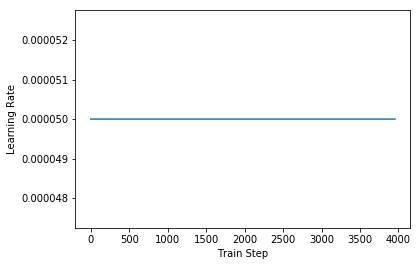

num_train_steps:  1978


In [73]:
# This is a workaround to plot, but it's very slow. So we plot the learning rate only when `num_train_steps` is small.
if num_train_steps <= 5000:
    xs = tf.range(2 * num_train_steps)
    ys = [learning_rate(x) for x in xs]
    plt.plot(xs, ys)
    
    plt.ylabel("Learning Rate")
    plt.xlabel("Train Step")
    plt.show()

print('num_train_steps: ', num_train_steps)

In [74]:
decay_var_list = []

for i in range(len(bert_nq.trainable_variables)):
    name = bert_nq.trainable_variables[i].name
    if any(x in name for x in ["LayerNorm", "layer_norm", "bias"]):
        decay_var_list.append(name)
        
decay_var_list

['tf_distil_bert_for_nq_1/pos_classifier/bias:0',
 'tf_distil_bert_for_nq_1/answer_type_classifier/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/embeddings/LayerNorm/gamma:0',
 'tf_distil_bert_for_nq_1/distilbert/embeddings/LayerNorm/beta:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/attention/q_lin/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/attention/k_lin/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/attention/v_lin/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/attention/out_lin/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/sa_layer_norm/gamma:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/sa_layer_norm/beta:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/ffn/lin1/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/ffn/lin2/bias:0',
 'tf_distil_bert_for_nq_1/distilbert/transformer/layer_._0/output_layer_norm/gamma:0',
 'tf_distil_b

In [75]:
from tensorflow.keras.optimizers import Adam
from adamw_optimizer import AdamW

# The hyperparameters are copied from AdamWeightDecayOptimizer in original bert code.
# (https://github.com/google-research/bert/blob/master/optimization.py#L25)
optimizer = AdamW(weight_decay=FLAGS.init_weight_decay_rate, learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay_var_list=decay_var_list)

In [76]:
checkpoint_path = '/home/jupyter/checkpoints/distilbert-base-uncased-distilled-squad'#os.path.join(FLAGS.input_checkpoint_dir, FLAGS.model_name)
ckpt = tf.train.Checkpoint(model=bert_nq)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10000)

In [77]:
print(checkpoint_path)

/home/jupyter/checkpoints/distilbert-base-uncased-distilled-squad


In [78]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print ('Latest BertNQ checkpoint restored -- Model trained for %d epochs' %(last_epoch))
else:
    print('Checkpoint not found. Train BertNQ from scratch')
    last_epoch = 0

Latest BertNQ checkpoint restored -- Model trained for 11 epochs


In [79]:
# Reset saving path, because the FLAGS.input_checkpoint_dir is not writable on Kaggle
print(ckpt_manager._directory)

/home/jupyter/checkpoints/distilbert-base-uncased-distilled-squad


In [80]:
ckpt_manager._directory = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
ckpt_manager._checkpoint_prefix = os.path.join(ckpt_manager._directory, "ckpt")
print(ckpt_manager._directory)

checkpoints/distilbert-base-uncased-distilled-squad


In [81]:
from tensorflow.python.lib.io.file_io import recursive_create_dir
recursive_create_dir(ckpt_manager._directory)

In [82]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

input_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
]

In [83]:
def get_loss_and_gradients(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):
    
    nq_inputs = (input_ids, input_masks, segment_ids)
    nq_labels = (start_pos_labels, end_pos_labels, answer_type_labels)

    with tf.GradientTape() as tape:

        nq_logits = bert_nq(nq_inputs, training=True)
        loss, loss_start_pos, loss_end_pos, loss_ans_type = loss_function(nq_labels, nq_logits)
                
    gradients = tape.gradient(loss, bert_nq.trainable_variables)        
        
    (start_pos_logits, end_pos_logits, answer_type_logits) = nq_logits
        
    train_acc.update_state(start_pos_labels, start_pos_logits)
    train_acc.update_state(end_pos_labels, end_pos_logits)
    train_acc.update_state(answer_type_labels, answer_type_logits)

    train_acc_start_pos.update_state(start_pos_labels, start_pos_logits)
    train_acc_end_pos.update_state(end_pos_labels, end_pos_logits)
    train_acc_ans_type.update_state(answer_type_labels, answer_type_logits)
    
    return loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type

In [84]:
@tf.function(input_signature=input_signature)
def train_step_simple(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):

    nb_examples = tf.math.reduce_sum(tf.cast(tf.math.not_equal(start_pos_labels, -2), tf.int32))
    
    loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type = get_loss_and_gradients(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels)
    
    average_loss = tf.math.divide(loss, tf.cast(nb_examples, tf.float32))
    
    # For this simple training step, it's better to use tf.math.reduce_mean() in loss_function() instead of tf.math.reduce_sum(), and not using the following line
    # to average gradients manually.
    
    # Using this line causing `UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape.`.
    average_gradients = [tf.divide(x, tf.cast(nb_examples, tf.float32)) for x in gradients]
    
    optimizer.apply_gradients(zip(gradients, bert_nq.trainable_variables))

    average_loss_start_pos = tf.math.divide(loss_start_pos, tf.cast(nb_examples, tf.float32))
    average_loss_end_pos = tf.math.divide(loss_end_pos, tf.cast(nb_examples, tf.float32))
    average_loss_ans_type = tf.math.divide(loss_ans_type, tf.cast(nb_examples, tf.float32))
    
    train_loss(average_loss)
    train_loss_start_pos(average_loss_start_pos)
    train_loss_end_pos(average_loss_end_pos)
    train_loss_ans_type(average_loss_ans_type)


In [85]:
@tf.function(input_signature=input_signature)
def train_step_with_batch_accumulation(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels):

    # This gets None! (probably due to input_signature)
    # batch_size = input_ids.shape[0]
    
    # Try this.
    nb_examples = tf.math.reduce_sum(tf.cast(tf.math.not_equal(start_pos_labels, -2), tf.int32))

    total_loss = 0.0
    total_loss_start_pos = 0.0
    total_loss_end_pos = 0.0
    total_loss_ans_type = 0.0
    
    total_gradients = [tf.constant(0, shape=x.shape, dtype=tf.float32) for x in bert_nq.trainable_variables]        
    ### total_gradients_sparse = [tf.IndexedSlices(values=tf.constant(0.0, shape=[1] + x.shape.as_list()[1:]), indices=tf.constant([0], dtype=tf.int32), dense_shape=x.shape.as_list()) for x in bert_nq.trainable_variables]        

    for idx in tf.range(FLAGS.batch_accumulation_size):    
                
        start_idx = FLAGS.train_batch_size * idx
        end_idx = FLAGS.train_batch_size * (idx + 1)
        
        if start_idx >= nb_examples:
            break

        (input_ids_mini, input_masks_mini, segment_ids_mini) = (input_ids[start_idx:end_idx], input_masks[start_idx:end_idx], segment_ids[start_idx:end_idx])
        (start_pos_labels_mini, end_pos_labels_mini, answer_type_labels_mini) = (start_pos_labels[start_idx:end_idx], end_pos_labels[start_idx:end_idx], answer_type_labels[start_idx:end_idx])
        
        loss, gradients, loss_start_pos, loss_end_pos, loss_ans_type = get_loss_and_gradients(input_ids_mini, input_masks_mini, segment_ids_mini, start_pos_labels_mini, end_pos_labels_mini, answer_type_labels_mini)
        
        total_loss += loss
        total_loss_start_pos += loss_start_pos
        total_loss_end_pos += loss_end_pos
        total_loss_ans_type += loss_ans_type
        
        total_gradients = [x + y for x, y in zip(total_gradients, gradients)]        
        ### total_gradients_sparse = [_add_grads_for_var(x, y) for x, y in zip(total_gradients_sparse, gradients)]

    average_loss = tf.math.divide(total_loss, tf.cast(nb_examples, tf.float32))        
    average_gradients = [tf.divide(x, tf.cast(nb_examples, tf.float32)) for x in total_gradients]
    ### average_gradients_sparse = [tf.scalar_mul(tf.divide(1.0, tf.cast(nb_examples, tf.float32)), x) for x in total_gradients_sparse]
    
    optimizer.apply_gradients(zip(average_gradients, bert_nq.trainable_variables))
    ### optimizer.apply_gradients(zip(average_gradients_sparse, bert_nq.trainable_variables))

    average_loss_start_pos = tf.math.divide(total_loss_start_pos, tf.cast(nb_examples, tf.float32))
    average_loss_end_pos = tf.math.divide(total_loss_end_pos, tf.cast(nb_examples, tf.float32))
    average_loss_ans_type = tf.math.divide(total_loss_ans_type, tf.cast(nb_examples, tf.float32))    
    
    train_loss(average_loss)
    train_loss_start_pos(average_loss_start_pos)
    train_loss_end_pos(average_loss_end_pos)
    train_loss_ans_type(average_loss_ans_type)


In [86]:
train_step = train_step_simple
if FLAGS.batch_accumulation_size > 1:
    train_step = train_step_with_batch_accumulation

In [87]:
# Because the previous checkpoint manager (for loading model) is created with a path which is read-only, ckpt_manager.save() fails here.
# So we create another checkpoint manager for saving checkpoints.
# checkpoint_path = os.path.join(FLAGS.output_checkpoint_dir, FLAGS.model_name)
# ckpt = tf.train.Checkpoint(model=bert_nq, optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

train_start_time = datetime.datetime.now()


In [88]:
epochs = FLAGS.epochs
for epoch in range(epochs):

    train_dataset = get_dataset(
        FLAGS.train_tf_record,
        FLAGS.max_seq_length_for_training,
        FLAGS.batch_accumulation_size * FLAGS.train_batch_size,
        FLAGS.shuffle_buffer_size,
        is_training=True
    )     
    
    train_loss.reset_states()
    train_loss_start_pos.reset_states()
    train_loss_end_pos.reset_states()
    train_loss_ans_type.reset_states()    
    
    train_acc.reset_states()
    train_acc_start_pos.reset_states()
    train_acc_end_pos.reset_states()
    train_acc_ans_type.reset_states()
    
    epoch_start_time = datetime.datetime.now()
    
    for (batch_idx, (features, targets)) in enumerate(train_dataset):
        
        # If the training is on kaggle, we stop the training after 8h45m, so we can get the checkpoints!
        if IS_KAGGLE and (datetime.datetime.now() - train_start_time).total_seconds() > 31500:
            break
        
        (input_ids, input_masks, segment_ids) = (features['input_ids'], features['input_mask'], features['segment_ids'])
        (start_pos_labels, end_pos_labels, answer_type_labels) = (targets['start_positions'], targets['end_positions'], targets['answer_types'])
    
        batch_start_time = datetime.datetime.now()
        
        train_step(input_ids, input_masks, segment_ids, start_pos_labels, end_pos_labels, answer_type_labels)

        batch_end_time = datetime.datetime.now()
        batch_elapsed_time = (batch_end_time - batch_start_time).total_seconds()
        
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {} | Batch {} | Elapsed Time {}'.format(
                epoch + 1,
                batch_idx + 1,
                batch_elapsed_time
            ))
            print('Loss {:.6f} | Loss_S {:.6f} | Loss_E {:.6f} | Loss_T {:.6f}'.format(
                train_loss.result(),
                train_loss_start_pos.result(),
                train_loss_end_pos.result(),
                train_loss_ans_type.result()
            ))
            print(' Acc {:.6f} |  Acc_S {:.6f} |  Acc_E {:.6f} |  Acc_T {:.6f}'.format(
                train_acc.result(),
                train_acc_start_pos.result(),
                train_acc_end_pos.result(),
                train_acc_ans_type.result()
            ))
            print("-" * 100)
       
    epoch_end_time = datetime.datetime.now()
    epoch_elapsed_time = (epoch_end_time - epoch_start_time).total_seconds()
            
    if (epoch + 1) % 1 == 0:
        
        ckpt_save_path = ckpt_manager.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
        print('\nEpoch {}'.format(epoch + 1))
        print('Loss {:.6f} | Loss_S {:.6f} | Loss_E {:.6f} | Loss_T {:.6f}'.format(
            train_loss.result(),
            train_loss_start_pos.result(),
            train_loss_end_pos.result(),
            train_loss_ans_type.result()
        ))
        print(' Acc {:.6f} |  Acc_S {:.6f} |  Acc_E {:.6f} |  Acc_T {:.6f}'.format(
            train_acc.result(),
            train_acc_start_pos.result(),
            train_acc_end_pos.result(),
            train_acc_ans_type.result()
        ))

    print('\nTime taken for 1 epoch: {} secs\n'.format(epoch_elapsed_time))
    print("-" * 80 + "\n")

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1 | Batch 100 | Elapsed Time 16.804331
Loss 0.230989 | Loss_S 0.275093 | Loss_E 0.291933 | Loss_T 0.125940
 Acc 0.927253 |  Acc_S 0.912480 |  Acc_E 0.914500 |  Acc_T 0.954780
----------------------------------------------------------------------------------------------------
Epoch 1 | Batch 200 | Elapsed Time 16.707431
Loss 0.235951 | Loss_S 0.280500 | Loss_E 0.297390 | Loss_T 0.129964
 Acc 0.926197 |  Acc_S 0.911530 |  Acc_E 0.913020 |  Acc_T 0.954040
----------------------------------------------------------------------------------------------------
Epoch 1 | Batch 300 | Elapsed Time 16.738065
Loss 0.235691 | Loss_S 0.279430 | Loss_E 0.297631 | Loss_T 0.130012
 Acc 0.926427 |  Acc_S 0.912200 |  Acc_E 0.913280 |  Acc_T 0.953800
----------------------------------------------------------------------------------------------------
Epoch 1 | Batch 400 | Elapsed Time 16.782648
Loss 0.237051 | Loss_S 0.282090 | Loss_E 0.298239 | Loss_T 0.130823
 Acc 0.925983 |  Acc_S 0.911155 |  Acc_E 

In [89]:
print(ckpt_manager._directory)

checkpoints/distilbert-base-uncased-distilled-squad


In [90]:
sy_cmd = 'ls -l ' + ckpt_manager._directory + ' > results.txt'
sy_cmd

'ls -l checkpoints/distilbert-base-uncased-distilled-squad > results.txt'

In [91]:
os.system(sy_cmd)

0

In [92]:
with open("results.txt", "r", encoding="UTF-8") as fp:
    for line in fp:
        print(line.strip())

total 777864
-rw-r--r-- 1 jupyter jupyter      2050 Jan 10 06:52 checkpoint
-rw-r--r-- 1 jupyter jupyter   1594684 Jan  9 16:01 ckpt-11.data-00000-of-00002
-rw-r--r-- 1 jupyter jupyter 263900188 Jan  9 16:01 ckpt-11.data-00001-of-00002
-rw-r--r-- 1 jupyter jupyter      7421 Jan  9 16:01 ckpt-11.index
-rw-r--r-- 1 jupyter jupyter   1594684 Jan 10 02:44 ckpt-12.data-00000-of-00002
-rw-r--r-- 1 jupyter jupyter 263900188 Jan 10 02:44 ckpt-12.data-00001-of-00002
-rw-r--r-- 1 jupyter jupyter      7421 Jan 10 02:44 ckpt-12.index
-rw-r--r-- 1 jupyter jupyter   1594684 Jan 10 06:52 ckpt-13.data-00000-of-00002
-rw-r--r-- 1 jupyter jupyter 263900188 Jan 10 06:52 ckpt-13.data-00001-of-00002
-rw-r--r-- 1 jupyter jupyter      7421 Jan 10 06:52 ckpt-13.index
-rw-r--r-- 1 root    root          165 Jan  9 22:14 dataset-metadata.json


In [93]:
with open(ckpt_manager._directory+"/checkpoint", "r", encoding="UTF-8") as fp:
    for line in fp:
        print(line.strip())

model_checkpoint_path: "ckpt-13"
all_model_checkpoint_paths: "../../../../input/nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-1"
all_model_checkpoint_paths: "../../../../input/nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-2"
all_model_checkpoint_paths: "../../../../input/nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-3"
all_model_checkpoint_paths: "../../../../nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-4"
all_model_checkpoint_paths: "../../../../nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-5"
all_model_checkpoint_paths: "../../../../nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-6"
all_model_checkpoint_paths: "../../../../nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-7"
all_model_checkpoint_paths: "../../../../nq-competition/checkpoints/distilbert-base-uncased-distilled-squad/ckpt-8"
all_model_checkpoint_

In [94]:
dsfsd

NameError: name 'dsfsd' is not defined